In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import copy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, efficientnet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization, Flatten, Input, Conv1D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import pathlib
import PIL
import PIL.Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/annotations/cardatasettrain.csv
/kaggle/input/annotations/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/annotations/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
/kaggle/input/stanford-cars-dataset/cars_annos.mat
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/05938.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/06122.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/04168.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/02371.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/04377.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/00767.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/07457.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/02360.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/05222.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/03999.jpg
/kaggle/input/stanford-cars-dataset/cars_test/cars_test/00266.jpg
/kaggle/i

# Handling training data

In [2]:
car_models = [
    'AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008',
    'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 
    'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012',
    'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 
    'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 
    'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 
    'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 
    'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012',
    'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012',
    'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 
    'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 
    'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012', 'Bentley Continental Supersports Conv. Convertible 2012',
    'Bentley Arnage Sedan 2009', 'Bentley Mulsanne Sedan 2011', 'Bentley Continental GT Coupe 2012',
    'Bentley Continental GT Coupe 2007', 'Bentley Continental Flying Spur Sedan 2007', 
    'Bugatti Veyron 16.4 Convertible 2009', 'Bugatti Veyron 16.4 Coupe 2009', 
    'Buick Regal GS 2012', 'Buick Rainier SUV 2007', 'Buick Verano Sedan 2012', 'Buick Enclave SUV 2012',
    'Cadillac CTS-V Sedan 2012', 'Cadillac SRX SUV 2012', 'Cadillac Escalade EXT Crew Cab 2007',
    'Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 'Chevrolet Corvette Convertible 2012',
    'Chevrolet Corvette ZR1 2012', 'Chevrolet Corvette Ron Fellows Edition Z06 2007',
    'Chevrolet Traverse SUV 2012', 'Chevrolet Camaro Convertible 2012', 'Chevrolet HHR SS 2010',
    'Chevrolet Impala Sedan 2007', 'Chevrolet Tahoe Hybrid SUV 2012', 'Chevrolet Sonic Sedan 2012',
    'Chevrolet Express Cargo Van 2007', 'Chevrolet Avalanche Crew Cab 2012', 'Chevrolet Cobalt SS 2010',
    'Chevrolet Malibu Hybrid Sedan 2010', 'Chevrolet TrailBlazer SS 2009', 'Chevrolet Silverado 2500HD Regular Cab 2012',
    'Chevrolet Silverado 1500 Classic Extended Cab 2007', 'Chevrolet Express Van 2007',
    'Chevrolet Monte Carlo Coupe 2007', 'Chevrolet Malibu Sedan 2007',
    'Chevrolet Silverado 1500 Extended Cab 2012', 'Chevrolet Silverado 1500 Regular Cab 2012',
    'Chrysler Aspen SUV 2009', 'Chrysler Sebring Convertible 2010', 'Chrysler Town and Country Minivan 2012',
    'Chrysler 300 SRT-8 2010', 'Chrysler Crossfire Convertible 2008', 'Chrysler PT Cruiser Convertible 2008',
    'Daewoo Nubira Wagon 2002', 'Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007',
    'Dodge Caravan Minivan 1997', 'Dodge Ram Pickup 3500 Crew Cab 2010', 'Dodge Ram Pickup 3500 Quad Cab 2009',
    'Dodge Sprinter Cargo Van 2009', 'Dodge Journey SUV 2012', 'Dodge Dakota Crew Cab 2010',
    'Dodge Dakota Club Cab 2007', 'Dodge Magnum Wagon 2008', 'Dodge Challenger SRT8 2011',
    'Dodge Durango SUV 2012', 'Dodge Durango SUV 2007', 'Dodge Charger Sedan 2012',
    'Dodge Charger SRT-8 2009', 'Eagle Talon Hatchback 1998', 'FIAT 500 Abarth 2012', 
    'FIAT 500 Convertible 2012', 'Ferrari FF Coupe 2012', 'Ferrari California Convertible 2012',
    'Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012', 'Fisker Karma Sedan 2012',
    'Ford F-450 Super Duty Crew Cab 2012', 'Ford Mustang Convertible 2007', 'Ford Freestar Minivan 2007',
    'Ford Expedition EL SUV 2009', 'Ford Edge SUV 2012', 'Ford Ranger SuperCab 2011',
    'Ford GT Coupe 2006', 'Ford F-150 Regular Cab 2012', 'Ford F-150 Regular Cab 2007',
    'Ford Focus Sedan 2007', 'Ford E-Series Wagon Van 2012', 'Ford Fiesta Sedan 2012',
    'GMC Terrain SUV 2012', 'GMC Savana Van 2012', 'GMC Yukon Hybrid SUV 2012', 'GMC Acadia SUV 2012',
    'GMC Canyon Extended Cab 2012', 'Geo Metro Convertible 1993', 'HUMMER H3T Crew Cab 2010',
    'HUMMER H2 SUT Crew Cab 2009', 'Honda Odyssey Minivan 2012', 'Honda Odyssey Minivan 2007',
    'Honda Accord Coupe 2012', 'Honda Accord Sedan 2012', 'Hyundai Veloster Hatchback 2012',
    'Hyundai Santa Fe SUV 2012', 'Hyundai Tucson SUV 2012', 'Hyundai Veracruz SUV 2012',
    'Hyundai Sonata Hybrid Sedan 2012', 'Hyundai Elantra Sedan 2007', 'Hyundai Accent Sedan 2012',
    'Hyundai Genesis Sedan 2012', 'Hyundai Sonata Sedan 2012', 'Hyundai Elantra Touring Hatchback 2012',
    'Hyundai Azera Sedan 2012', 'Infiniti G Coupe IPL 2012', 'Infiniti QX56 SUV 2011',
    'Isuzu Ascender SUV 2008', 'Jaguar XK XKR 2012', 'Jeep Patriot SUV 2012', 'Jeep Wrangler SUV 2012',
    'Jeep Liberty SUV 2012', 'Jeep Grand Cherokee SUV 2012', 'Jeep Compass SUV 2012',
    'Lamborghini Reventon Coupe 2008', 'Lamborghini Aventador Coupe 2012',
    'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Lamborghini Diablo Coupe 2001',
    'Land Rover Range Rover SUV 2012', 'Land Rover LR2 SUV 2012', 'Lincoln Town Car Sedan 2011',
    'MINI Cooper Roadster Convertible 2012', 'Maybach Landaulet Convertible 2012', 'Mazda Tribute SUV 2011',
    'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993', 'Mercedes-Benz C-Class Sedan 2012',
    'Mercedes-Benz SL-Class Coupe 2009', 'Mercedes-Benz E-Class Sedan 2012', 'Mercedes-Benz S-Class Sedan 2012',
    'Mercedes-Benz Sprinter Van 2012', 'Mitsubishi Lancer Sedan 2012', 'Nissan Leaf Hatchback 2012',
    'Nissan NV Passenger Van 2012', 'Nissan Juke Hatchback 2012', 'Nissan 240SX Coupe 1998',
    'Plymouth Neon Coupe 1999', 'Porsche Panamera Sedan 2012', 'Ram C/V Cargo Van Minivan 2012',
    'Rolls-Royce Phantom Drophead Coupe Convertible 2012', 'Rolls-Royce Ghost Sedan 2012',
    'Rolls-Royce Phantom Sedan 2012', 'Scion xD Hatchback 2012', 'Spyker C8 Convertible 2009',
    'Spyker C8 Coupe 2009', 'Suzuki Aerio Sedan 2007', 'Suzuki Kizashi Sedan 2012',
    'Suzuki SX4 Hatchback 2012', 'Suzuki SX4 Sedan 2012', 'Tesla Model S Sedan 2012',
    'Toyota Sequoia SUV 2012', 'Toyota Camry Sedan 2012', 'Toyota Corolla Sedan 2012',
    'Toyota 4Runner SUV 2012', 'Volkswagen Golf Hatchback 2012', 'Volkswagen Golf Hatchback 1991',
    'Volkswagen Beetle Hatchback 2012', 'Volvo C30 Hatchback 2012', 'Volvo 240 Sedan 1993',
    'Volvo XC90 SUV 2007', 'smart fortwo Convertible 2012']

In [3]:
#Got the data of the cars_annos.mat file as a CSV file
anno = pd.read_csv('/kaggle/input/annotations/cardatasettrain.csv')

In [4]:
anno.head()

Unnamed: 0   x1   y1    x2    y2  Class      image
0           0   39  116   569   375     14  00001.jpg
1           1   36  116   868   587      3  00002.jpg
2           2   85  109   601   381     91  00003.jpg
3           3  621  393  1484  1096    134  00004.jpg
4           4   14   36   133    99    106  00005.jpg

In [5]:
anno.tail()

Unnamed: 0   x1   y1    x2   y2  Class      image
8139        8139    3   44   423  336     78  08140.jpg
8140        8140  138  150   706  523    196  08141.jpg
8141        8141   26  246   660  449    163  08142.jpg
8142        8142   78  526  1489  908    112  08143.jpg
8143        8143   20  240   862  677     17  08144.jpg

In [6]:
anno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8144 non-null   int64 
 1   x1          8144 non-null   int64 
 2   y1          8144 non-null   int64 
 3   x2          8144 non-null   int64 
 4   y2          8144 non-null   int64 
 5   Class       8144 non-null   int64 
 6   image       8144 non-null   object
dtypes: int64(6), object(1)
memory usage: 445.5+ KB


In [7]:
anno.describe()

Unnamed: 0           x1           y1           x2           y2  \
count  8144.000000  8144.000000  8144.000000  8144.000000  8144.000000   
mean   4071.500000    64.906803   108.661223   638.208620   416.431606   
std    2351.114629    82.198684   104.551635   410.776734   273.786000   
min       0.000000     1.000000     1.000000    76.000000    47.000000   
25%    2035.750000    19.000000    42.000000   392.000000   248.000000   
50%    4071.500000    39.000000    80.000000   569.000000   360.000000   
75%    6107.250000    79.000000   138.250000   746.250000   477.000000   
max    8143.000000  1648.000000  1508.000000  5205.000000  3389.000000   

             Class  
count  8144.000000  
mean     98.979371  
std      56.503148  
min       1.000000  
25%      50.000000  
50%      99.000000  
75%     148.000000  
max     196.000000

In [8]:
def load_and_preprocess_image(image_path, label):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [224, 224])  # Resize images to 224x224, adjust as needed
        image = image / 255.0  # Normalize pixel values to [0,1]
        
        label = tf.clip_by_value(label, 0, 195)
    except NotFoundError as e:
        print(f"File not found: {image_path}")
        return None, label  # Skip this image
    return image, label

In [9]:
# Define the path to the directory containing the images
cars_dir = pathlib.Path('/kaggle/input/stanford-cars-dataset/cars_train/cars_train')

if cars_dir.exists():
    image_count = len(list(cars_dir.glob('**/*.jpg')))
    file_paths = [str(cars_dir / f) for f in cars_dir.glob('**/*.jpg')]
    print(f'Number of image files: {image_count}')
else:
    print("The specified path does not exist.")


Number of image files: 8144


In [10]:
image_paths = [os.path.join(cars_dir, fname) for fname in anno['image']]
labels = anno['Class'].astype('category')
print(labels)
print(labels.shape)

0        14
1         3
2        91
3       134
4       106
       ... 
8139     78
8140    196
8141    163
8142    112
8143     17
Name: Class, Length: 8144, dtype: category
Categories (196, int64): [1, 2, 3, 4, ..., 193, 194, 195, 196]
(8144,)


In [11]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_and_preprocess_image)
# Split the dataset into training and validation sets
#train_size = int(0.8 * len(image_paths))
train_dataset = dataset
#val_dataset = dataset.skip(train_size)
# Batch and shuffle the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
len(train_dataset)

255

tf.Tensor(
[151  87 142 185 131 195   7 103  90 165  12 156  66  24  91  68 178  50
  61  10  46  83 175  86 182 125 166 125  23 194  16  81], shape=(32,), dtype=int64)


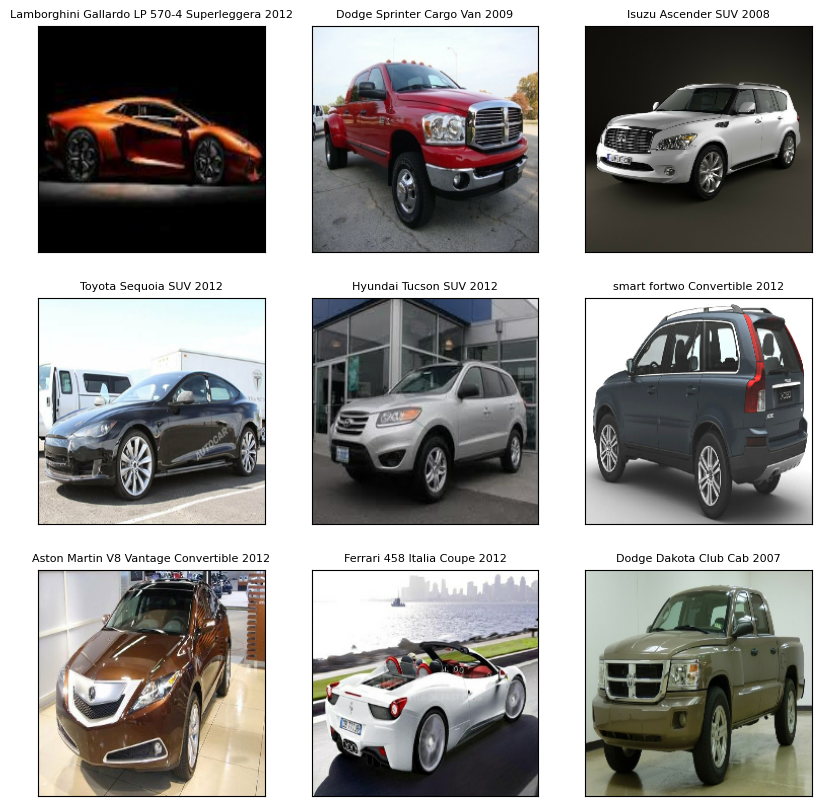

In [13]:
image_batch, label_batch = next(iter(train_dataset.take(1)))
print(label_batch)
# Display the images with their corresponding labels
plt.figure(figsize=(10, 10))
for i in range(min(len(image_batch), 9)):  # Limit to 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(str(car_models[label_batch[i].numpy()]), fontsize=8)
plt.show()

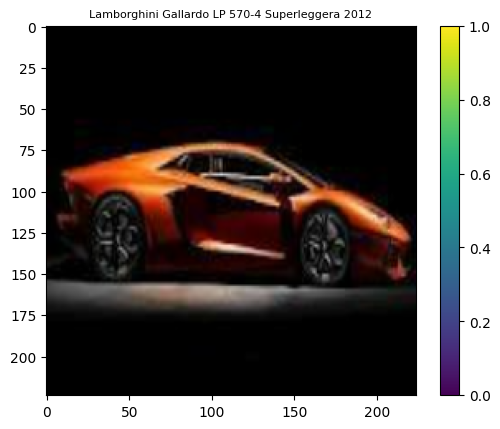

In [14]:
plt.figure()
plt.imshow(image_batch[0])
plt.title(car_models[label_batch[0]], fontsize=8)
plt.colorbar()
plt.grid(False)
plt.show()

# Training the model

### I will train the model on a pre-trained CNN model "MobileNetV2"

In [15]:
# Here I manually downloaded the pre_trained weights of the model into a new dataset and feed it to the model
mobilenet_model = MobileNetV2(include_top=False,
                                    weights='/kaggle/input/annotations/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5',
                                    input_shape=(224, 224, 3))

In [16]:
for layer in mobilenet_model.layers:
    layer.trainable = False
    
x = GlobalAveragePooling2D()(mobilenet_model.output)
x = BatchNormalization()(x)
x = Dense(units=1024,
          activation='relu',kernel_regularizer=regularizers.l2(0.01), 
          kernel_initializer='random_uniform',
          bias_initializer='zeros')(x)

x = BatchNormalization()(x)
output = Dense(units=196, activation='softmax')(x)

## creating the extended model
model = Model(inputs=mobilenet_model.input, outputs=output)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,779,844 (14.42 MB)

 Trainable params: 1,517,252 (5.79 MB)

 Non-trainable params: 2,262,592 (8.63 MB)

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, epochs=5)

Epoch 1/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 203s 757ms/step - accuracy: 0.0329 - loss: 16.0184
Epoch 2/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 201s 755ms/step - accuracy: 0.2866 - loss: 12.6145
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 196s 757ms/step - accuracy: 0.5166 - loss: 10.5580
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 197s 762ms/step - accuracy: 0.6892 - loss: 8.9194
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 205s 773ms/step - accuracy: 0.8148 - loss: 7.5632


# Handling test data

In [20]:
test_path = pathlib.Path('/kaggle/input/stanford-cars-dataset/cars_test/cars_test')

image_count = len(list(test_path.glob('**/*.jpg')))
file_paths = [str(cars_dir / f) for f in filenames]
print(image_count)

8041


In [21]:
image_paths = [os.path.join(cars_dir, fname) for fname in anno['image']]
labels = anno['Class'].astype('category')
print(labels)
print(labels.shape)

0        14
1         3
2        91
3       134
4       106
       ... 
8139     78
8140    196
8141    163
8142    112
8143     17
Name: Class, Length: 8144, dtype: category
Categories (196, int64): [1, 2, 3, 4, ..., 193, 194, 195, 196]
(8144,)


In [22]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
test_dataset = test_dataset.map(load_and_preprocess_image)

# Batch and shuffle the datasets
batch_size = 32
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
image_test_batch, label_test_batch = next(iter(test_dataset.take(1)))

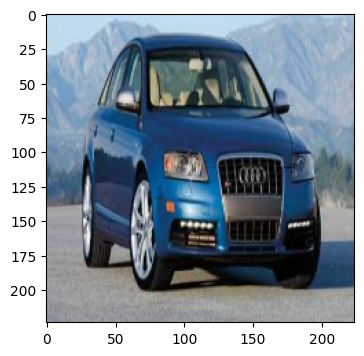

In [24]:
plt.figure(figsize=(4,4))
plt.imshow(image_test_batch[0])
    

# Making predictions on test data

In [32]:
test_loss, test_acc = model.evaluate(image_test_batch, label_test_batch, verbose=2)
print('\nTest accuracy:', test_acc)

1/1 - 1s - 727ms/step - accuracy: 0.9688 - loss: 6.4322

Test accuracy: 0.96875


In [33]:
predictions = model.predict(image_test_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


In [34]:
predictions[0]

array([5.37616761e-05, 2.32397324e-05, 1.95446846e-04, 1.49462096e-04,
       6.98782605e-05, 2.16744305e-03, 9.07159938e-06, 6.23057203e-05,
       4.43997051e-05, 3.01421707e-04, 3.61533944e-06, 3.30734074e-05,
       1.61338030e-04, 5.74475969e-04, 3.19125043e-04, 1.78288901e-05,
       2.35996180e-04, 7.73571432e-04, 3.15165217e-03, 3.97075899e-04,
       8.75495732e-01, 3.89595778e-04, 1.28952437e-04, 4.07324464e-04,
       4.90422186e-04, 8.75007754e-06, 5.35822241e-03, 1.92136995e-05,
       9.39578842e-03, 6.44803105e-04, 4.33340622e-03, 3.11499665e-04,
       4.64388588e-03, 1.27457932e-03, 5.22079587e-04, 2.21484993e-03,
       2.20003349e-05, 1.35502662e-03, 1.30154949e-04, 2.64241298e-05,
       9.16715653e-04, 6.89982902e-04, 2.78577092e-04, 7.53589848e-06,
       4.98875917e-04, 4.89395497e-05, 6.08037626e-05, 5.50387544e-04,
       4.46722552e-04, 1.13015674e-04, 3.82504550e-05, 2.07781835e-04,
       6.75346382e-05, 2.55846335e-05, 5.44689574e-05, 6.45163163e-06,
      

In [35]:
np.argmax(predictions[5])

131

In [37]:
car_models[np.argmax(predictions[5])]

'Hyundai Tucson SUV 2012'

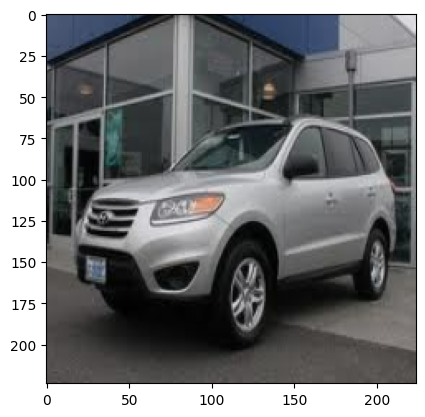

In [38]:
plt.figure()
plt.imshow(image_test_batch[5].numpy())

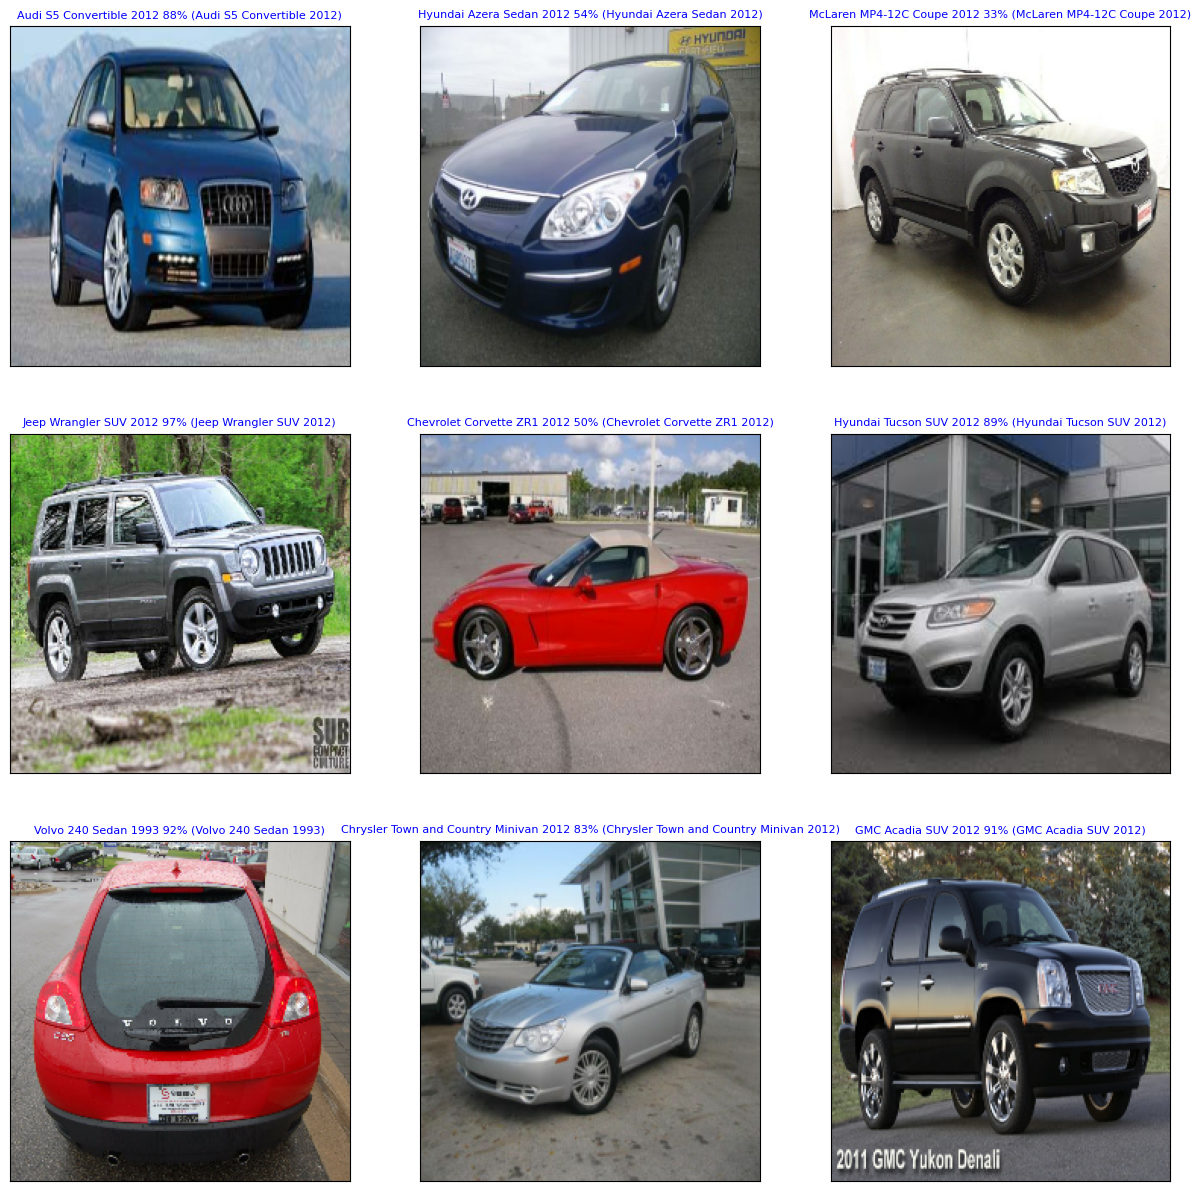

In [39]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(image_test_batch[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    predicted_label = np.argmax(predictions[i])
    if predicted_label == label_test_batch[i]:
        color = 'blue'
    else:
        color = 'red'
        
    plt.title("{} {:2.0f}% ({})".format(car_models[predicted_label],
                                100*np.max(predictions[i]),
                                car_models[label_test_batch[i]]),
                                color=color,
                                fontsize=8)
plt.show()